<div class="usecase-title"><h3>Route Planner</h3></div>

<div class="usecase-authors"><b>Authored by: </b> Chathumini Satharasinghe</div>

<div class="usecase-authors"><b>Date: </b> T2 2024 (July - October)</div>

<div class="usecase-duration"><b>Duration:</b> 270 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Beginner/ Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Power BI, Machine Learning</div>
</div>

### Analysis of Waste Collection, Pedestrian Activity, and Smart Bin Utilization in Melbourne

#### Introduction

This notebook provides an in-depth analysis of various datasets from Melbourne, Australia, focusing on waste collection trends, pedestrian activity, and the utilization of smart bins. By examining patterns in waste collection zones, pedestrian movements, and smart bin fill levels, the aim is to uncover insights that can help optimize waste management operations and city planning. The datasets used in this analysis include:

- **Pedestrian Counting System - Monthly Counts Per Hour**
- **Waste Collected Per Month**
- **Garbage Collection Zones**
- **Smart Bins Argyle Square**

The analysis considers seasonal trends, public events, geographical variations, and smart bin efficiency. The goal is to identify key factors influencing waste collection volumes, such as population density and public activities, and to propose data-driven solutions for improving waste management in Melbourne.


<h4>Datasets</h4>
<div class="usecase-subsection-blurb">
  <i>1. waste-collected-per-month </i> 
  <br>
  <a href="https://data.melbourne.vic.gov.au/explore/dataset/waste-collected-per-month/export/" target="_blank">Link to Dataset 1</a>
  <br>
</div>
<br>
<div class="usecase-subsection-blurb">
  <i>2. Smart bins Argyle Square </i> 
  <br>
  <a href="https://melbournetestbed.opendatasoft.com/explore/dataset/smart-bins-argyle-square/api/?disjunctive.serial" target="_blank">Link to Dataset 2</a>
  <br>
</div>

<div class="usecase-subsection-blurb">
  <i>3. garbage-collection-zones </i> 
  <br>
  <a href="https://data.melbourne.vic.gov.au/explore/dataset/garbage-collection-zones/information/" target="_blank">Link to Dataset 2</a>
  <br>
</div>

### Data Collection and Preparation

#### Fetching Smart Bin Data
This section covers the process of retrieving data from the Melbourne City API for smart bins located around Argyle Square. The data includes bin fill levels, bin status, and timestamps.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from scipy.stats import pearsonr, ttest_ind, f_oneway
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import geopandas as gpd
from shapely.geometry import shape

In [2]:
def fetch_data(base_url, dataset, num_records=99, offset=0):
    all_records = []
    max_offset = 9900  # Maximum number of requests

    while True:
        # Maximum limit check
        if offset > max_offset:
            break

        # Create API request URL
        filters = f'{dataset}/records?limit={num_records}&offset={offset}'
        url = f'{base_url}{filters}'

        # Start request
        try:
            result = requests.get(url, timeout=10)
            result.raise_for_status()
            records = result.json().get('results')
        except requests.exceptions.RequestException as e:
            raise Exception(f"API request failed: {e}")
        if records is None:
            break
        all_records.extend(records)
        if len(records) < num_records:
            break

        # Next cycle offset
        offset += num_records

    # DataFrame all data
    df = pd.DataFrame(all_records)
    return df

BASE_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'

#### Fetching Waste Collection Data
Describes the steps involved in pulling data from the Melbourne API regarding waste collection over time, focusing on categories such as residential, public litter bins, dumped rubbish, and street sweepings.

In [3]:
# Data set name
pedestrian = 'smart-bins-argyle-square'

smart_bins_df = fetch_data(BASE_URL, pedestrian)

smart_bins_df

,time,serial,sensor_name,status_current_fill_level,bin_status,last_update,product_type,description,address,latlong,wastebasket_size
0,2021-06-29T21:18:25+00:00,FB1000001905AA05,None,14,Low,None,CleanFLEX,Argyle - FB1000001905AA05,"Argyle Square, 13-19 Argyle Pl N, Carlton VIC ...","{'lon': 144.966267, 'lat': -37.802983}",None
1,2021-06-30T12:17:40+00:00,FB1000001905AA15,Internal Bin Sensor 2,49,Half Full,None,CleanFLEX,Argyle - FB1000001905AA15,"138-146 Cardigan St, Carlton VIC 3053, Australia","{'lon': 144.9655, 'lat': -37.802017}",None
2,2021-07-01T00:00:21+00:00,FB1000001905AA17,External Bin Sensor 1,100,Full,None,CleanFLEX,Argyle - FB1000001905AA17,"164 Lygon St, Carlton VIC 3053, Australia","{'lon': 144.9661, 'lat': -37.803217}",None
3,2021-06-30T16:19:28+00:00,FB1000001905AA07,Internal Bin Sensor 7,30,Half Full,None,CleanFLEX,Argyle - FB1000001905AA07,"Grattan Pl, Carlton VIC 3053, Australia","{'lon': 144.965233, 'lat': -37.803117}",None
4,2021-06-30T10:30:07+00:00,FB1000001905AA18,External Bin Sensor 2,0,Low,None,CleanFLEX,Argyle - FB1000001905AA18,"153 Lygon St, Carlton VIC 3053, Australia",None,None
...,...,...,...,...,...,...,...,...,...,...,...
9994,2021-05-22T14:48:45+00:00,FB1000001905AA07,Internal Bin Sensor 7,17,Low,None,CleanFLEX,Argyle - FB1000001905AA07,"Grattan Pl, Carlton VIC 3053, Australia","{'lon': 144.965233, 'lat': -37.803117}",None
9995,2021-05-22T15:14:25+00:00,FB1000001905AA16,External Bin Sensor 5,93,Full,None,CleanFLEX,Argyle - FB1000001905AA16,"126 Cardigan St, Carlton VIC 3053, Australia","{'lon': 144.965317, 'lat': -37.802533}",None
9996,2021-05-22T15:07:19+00:00,FB1000001905AA19,External Bin Sensor 3,16,Low,None,CleanFLEX,Argyle - FB1000001905AA19,"Lygon St & Argyle Pl N, Carlton VIC 3053, Aust...","{'lon': 144.9665, 'lat': -37.802233}",None
9997,2021-05-22T17:50:55+00:00,FB1000001905AA08,Internal Bin Sensor 8,100,Full,None,CleanFLEX,Argyle - FB1000001905AA08,"Piazza Italia, Unnamed Road, Carlton VIC 3053,...","{'lon': 144.965817, 'lat': -37.802617}",None


In [4]:
# Data set name
waste_month = 'waste-collected-per-month'

waste_collected_df = fetch_data(BASE_URL, waste_month)

waste_collected_df

,date,residential,public_litter_bins,dumped_rubbish,street_sweepings,mattresses,commingled_recycling,cardboard,hardwaste_to_landfill,hardwaste_recovered,hardwaste_total,green_waste,month
0,2015-02,1867.96,365.13,179.25,307.66,312,558.96,151.02,89.50,0.00,89.50,2.70,February
1,2011-02,1644.12,300.24,138.70,530.52,117,512.66,176.48,23.80,0.00,23.80,6.54,February
2,2014-08,1836.81,432.82,129.22,343.28,165,540.51,142.13,73.42,0.00,73.42,3.02,August
3,2009-10,1449.20,418.66,141.24,631.98,148,523.80,194.63,16.64,0.00,16.64,2.29,October
4,2009-11,1578.91,426.05,136.58,582.75,43,579.58,202.81,38.64,0.00,38.64,5.86,November
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2019-03,2752.70,286.00,140.00,319.78,675,562.46,72.45,72.82,17.48,90.30,7.84,March
128,2019-08,3298.58,320.16,72.08,246.70,466,0.00,90.44,89.52,29.09,118.61,6.62,August
129,2019-05,2479.20,289.10,167.46,401.78,485,890.68,72.38,63.54,27.65,91.19,10.04,May
130,2019-07,2794.24,247.22,118.62,270.82,520,694.78,74.90,91.24,40.44,131.68,14.82,July


In [5]:
# Data set name
waste_month = 'garbage-collection-zones'

garbage_zones_df = fetch_data(BASE_URL, waste_month)

garbage_zones_df

,geo_point_2d,geo_shape,desc,name,rec_ok,rec_weeks,rub_start,rub_ok,rub_day,info_url,rub_notok,rec_url,rec_name,rec_notok,rub_name,rec_day,rub_weeks,rec_start,rub_url,missed_ph
0,"{'lon': 144.946122910589, 'lat': -37.825972120...","{'type': 'Feature', 'geometry': {'coordinates'...",Bins must be placed out by 6am on collection d...,Tuesday,paper and cardboard; aluminium and steel cans;...,1,2015/09/22,"general rubbish, nappies (wrapped), meat/bones...",Tuesday,https://www.melbourne.vic.gov.au/ForResidents/...,"hot liquid or ashes; oil; chemicals, paints an...",https://www.melbourne.vic.gov.au/ForResidents/...,Recycling,"plastic bags; soft plastics; CDs, DVDs, VCR ta...",General waste,Tuesday,1,2015/09/22,https://www.melbourne.vic.gov.au/ForResidents/...,03 9658 9658
1,"{'lon': 144.96108202950762, 'lat': -37.7977702...","{'type': 'Feature', 'geometry': {'coordinates'...",Bins must be placed out by 6am on collection d...,Wednesday,paper and cardboard; aluminium and steel cans;...,1,2015/09/23,"general rubbish, nappies (wrapped), meat/bones...",Wednesday,https://www.melbourne.vic.gov.au/ForResidents/...,"hot liquid or ashes; oil; chemicals, paints an...",https://www.melbourne.vic.gov.au/ForResidents/...,Recycling,"plastic bags; soft plastics; CDs, DVDs, VCR ta...",General waste,Wednesday,1,2015/09/23,https://www.melbourne.vic.gov.au/ForResidents/...,03 9658 9658
2,"{'lon': 144.94807224053946, 'lat': -37.7888852...","{'type': 'Feature', 'geometry': {'coordinates'...",Bins must be placed out by 6am on collection d...,Monday,paper and cardboard; aluminium and steel cans;...,1,2015/09/21,"general rubbish, nappies (wrapped), meat/bones...",Monday,https://www.melbourne.vic.gov.au/ForResidents/...,"hot liquid or ashes; oil; chemicals, paints an...",https://www.melbourne.vic.gov.au/ForResidents/...,Recycling,"plastic bags; soft plastics; CDs, DVDs, VCR ta...",General waste,Monday,1,2015/09/21,https://www.melbourne.vic.gov.au/ForResidents/...,03 9658 9658
3,"{'lon': 144.92363364191561, 'lat': -37.8019946...","{'type': 'Feature', 'geometry': {'coordinates'...",Bins must be placed out by 6am on collection d...,Thursday,paper and cardboard; aluminium and steel cans;...,1,2015/09/24,"general rubbish, nappies (wrapped), meat/bones...",Thursday,https://www.melbourne.vic.gov.au/ForResidents/...,"hot liquid or ashes; oil; chemicals, paints an...",https://www.melbourne.vic.gov.au/ForResidents/...,Recycling,"plastic bags; soft plastics; CDs, DVDs, VCR ta...",General waste,Thursday,1,2015/09/24,https://www.melbourne.vic.gov.au/ForResidents/...,03 9658 9658
4,"{'lon': 144.98033118663488, 'lat': -37.8135006...","{'type': 'Feature', 'geometry': {'coordinates'...",Bins must be placed out by 6am on collection d...,Friday,paper and cardboard; aluminium and steel cans;...,1,2015/09/25,"general rubbish, nappies (wrapped), meat/bones...",Friday,https://www.melbourne.vic.gov.au/ForResidents/...,"hot liquid or ashes; oil; chemicals, paints an...",https://www.melbourne.vic.gov.au/ForResidents/...,Recycling,"plastic bags; soft plastics; CDs, DVDs, VCR ta...",General waste,Friday,1,2015/09/25,https://www.melbourne.vic.gov.au/ForResidents/...,03 9658 9658
5,"{'lon': 144.9329101787968, 'lat': -37.79143593...","{'type': 'Feature', 'geometry': {'coordinates'...",Bins must be placed out by 6am on collection d...,Tuesday,paper and cardboard; aluminium and steel cans;...,1,2015/09/22,"general rubbish, nappies (wrapped), meat/bones...",Tuesday,https://www.melbourne.vic.gov.au/ForResidents/...,"hot liquid or ashes; oil; chemicals, paints an...",https://www.melbourne.vic.gov.au/ForResidents/...,Recycling,"plastic bags; soft plastics; CDs, DVDs, VCR ta...",General waste,Tuesday,1,2015/09/22,https://www.melbourne.vic.gov.au/ForResidents/...,03 9658 9658


#### Data Cleaning and Transformation
Covers how missing values in the datasets are handled and the process of converting columns such as 'date' to the appropriate `datetime` format for analysis.

In [6]:
# Convert the 'date' column in waste_collected_df to datetime format
waste_collected_df['date'] = pd.to_datetime(waste_collected_df['date'], format='%Y-%m')

# Extract year and month for analysis
waste_collected_df['year'] = waste_collected_df['date'].dt.year
waste_collected_df['month'] = waste_collected_df['date'].dt.month

In [7]:
# Group by year and month to calculate the total waste collected
monthly_waste_trends = waste_collected_df.groupby(['year', 'month']).sum(numeric_only=True).reset_index()

# Recreate the 'date' column by combining the 'year' and 'month' columns for plotting
monthly_waste_trends['date'] = pd.to_datetime(monthly_waste_trends[['year', 'month']].assign(day=1))

#### Extracting Time-Based Features
Explains how year, month, and day information are extracted from the timestamp data to facilitate time series analysis and seasonal trends in waste collection.


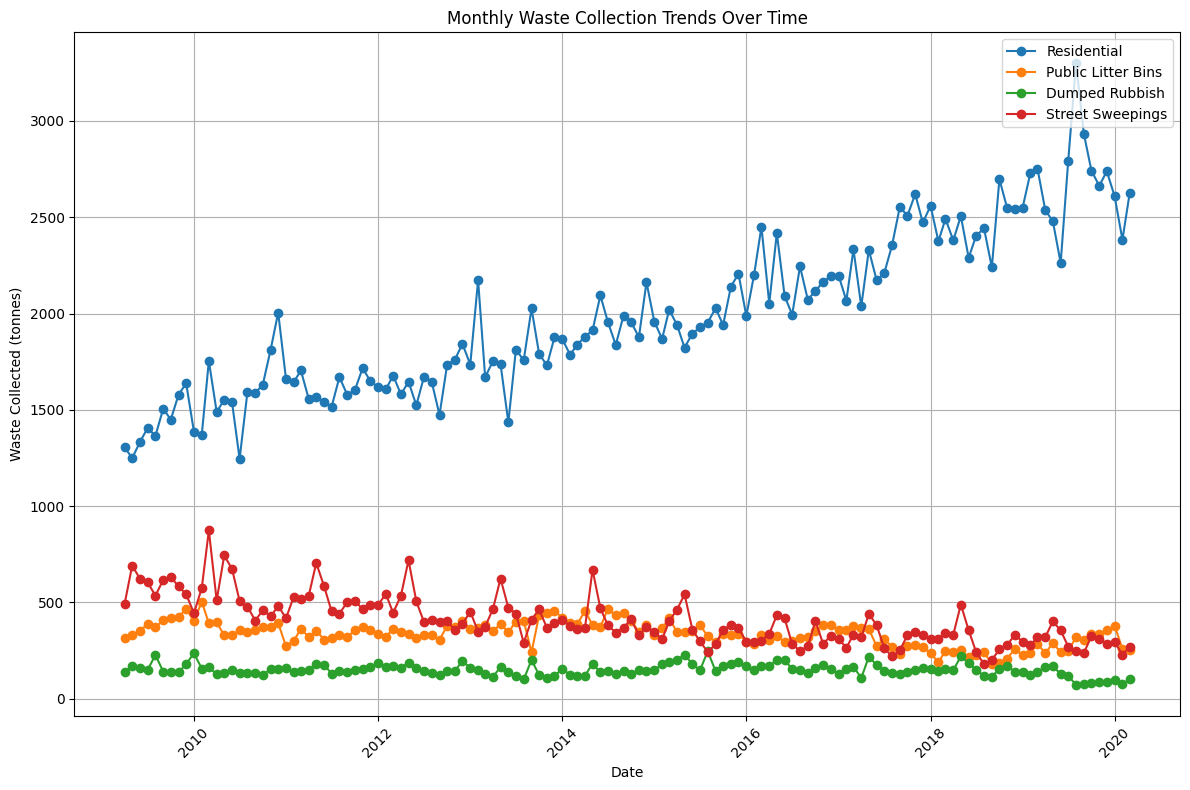

In [8]:
# Plotting the time series for different waste categories
plt.figure(figsize=(12, 8))
plt.plot(monthly_waste_trends['date'], monthly_waste_trends['residential'], label='Residential', marker='o')
plt.plot(monthly_waste_trends['date'], monthly_waste_trends['public_litter_bins'], label='Public Litter Bins', marker='o')
plt.plot(monthly_waste_trends['date'], monthly_waste_trends['dumped_rubbish'], label='Dumped Rubbish', marker='o')
plt.plot(monthly_waste_trends['date'], monthly_waste_trends['street_sweepings'], label='Street Sweepings', marker='o')

# Adding labels and title for time-based analysis
plt.xlabel('Date')
plt.ylabel('Waste Collected (tonnes)')
plt.title('Monthly Waste Collection Trends Over Time')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Monthly Waste Collection Trends Over Time
Visualizes the total monthly waste collection for different categories (residential, public litter bins, dumped rubbish, and street sweepings). The graph identifies any seasonality or changes in waste collection trends over time.


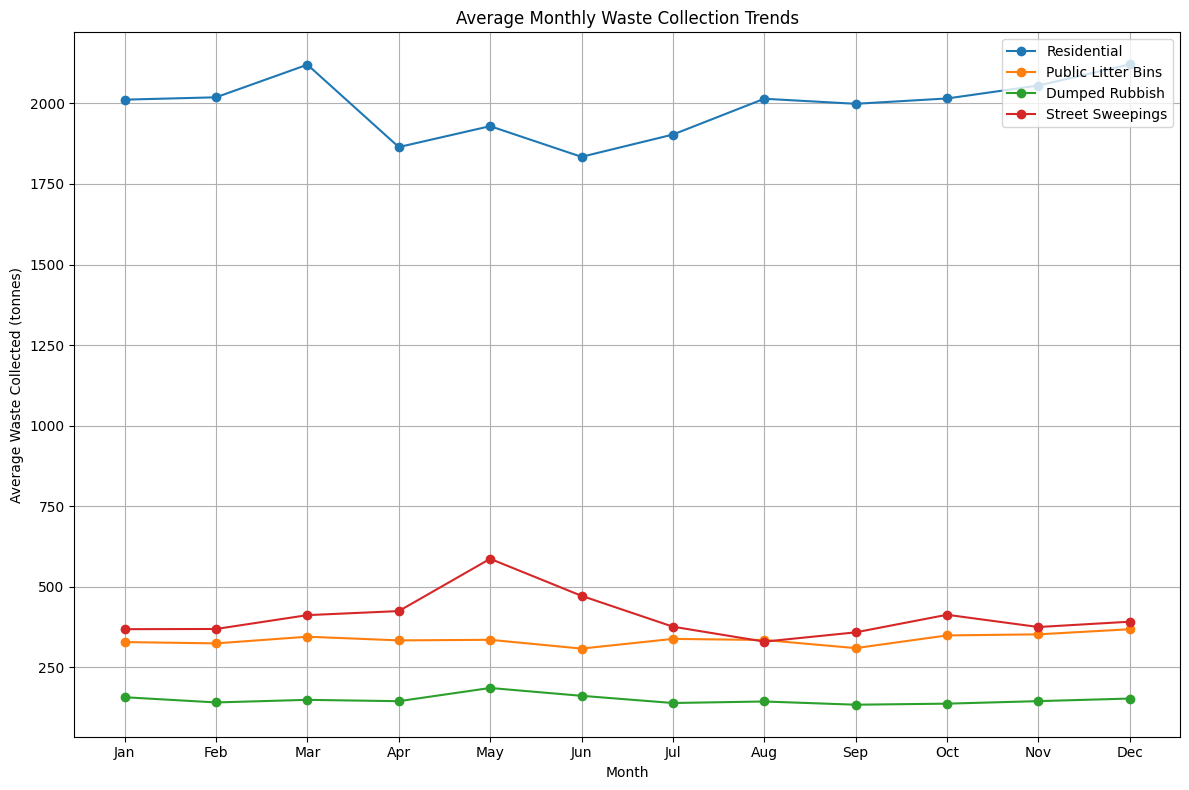

In [9]:
# Grouping by month to analyze seasonality
seasonal_trends = waste_collected_df.groupby('month').mean(numeric_only=True).reset_index()

# Plotting seasonal trends for different waste categories
plt.figure(figsize=(12, 8))
plt.plot(seasonal_trends['month'], seasonal_trends['residential'], label='Residential', marker='o')
plt.plot(seasonal_trends['month'], seasonal_trends['public_litter_bins'], label='Public Litter Bins', marker='o')
plt.plot(seasonal_trends['month'], seasonal_trends['dumped_rubbish'], label='Dumped Rubbish', marker='o')
plt.plot(seasonal_trends['month'], seasonal_trends['street_sweepings'], label='Street Sweepings', marker='o')

# Adding labels and title for seasonal analysis
plt.xlabel('Month')
plt.ylabel('Average Waste Collected (tonnes)')
plt.title('Average Monthly Waste Collection Trends')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

### Waste Collection Analysis

#### Statistical Analysis of Waste Collection by Category
Presents a t-test analysis comparing waste collection during event periods vs non-event periods for residential waste, public litter bins, dumped rubbish, and street sweepings. Includes results like t-statistics and p-values for each category.

In [10]:
# Load waste collection data (already loaded earlier)
waste_collected_df['date'] = pd.to_datetime(waste_collected_df['date'], format='%Y-%m')

# Add a new column to indicate events
waste_collected_df['event'] = 0  # Initialize with no event


In [11]:
# Define known local events and holidays (example dates; replace with actual events)
events = {
    'New Year': ['2024-01-01', '2023-01-01', '2022-01-01'],
    'Australia Day': ['2024-01-26', '2023-01-26', '2022-01-26'],
    'Melbourne Cup': ['2024-11-05', '2023-11-07', '2022-11-01'],
    'Christmas': ['2024-12-25', '2023-12-25', '2022-12-25'],
    # Add other relevant events here
}

In [12]:
# Convert event dates to datetime and flag them in the dataset
for event_name, dates in events.items():
    event_dates = pd.to_datetime(dates)
    waste_collected_df.loc[waste_collected_df['date'].isin(event_dates), 'event'] = 1

# Separate data into event and non-event periods
event_data = waste_collected_df[waste_collected_df['event'] == 1]
non_event_data = waste_collected_df[waste_collected_df['event'] == 0]

In [13]:
# Perform statistical analysis to compare waste during event and non-event periods
results = {}
for category in ['residential', 'public_litter_bins', 'dumped_rubbish', 'street_sweepings']:
    event_waste = event_data[category].dropna()
    non_event_waste = non_event_data[category].dropna()
    t_stat, p_val = ttest_ind(event_waste, non_event_waste, equal_var=False)
    results[category] = {'t_stat': t_stat, 'p_val': p_val}

# Display the results of statistical analysis
print("Statistical Analysis Results:")
for category, result in results.items():
    print(f"{category}: t-statistic = {result['t_stat']:.3f}, p-value = {result['p_val']:.3f}")

Statistical Analysis Results:
residential: t-statistic = nan, p-value = nan
public_litter_bins: t-statistic = nan, p-value = nan
dumped_rubbish: t-statistic = nan, p-value = nan
street_sweepings: t-statistic = nan, p-value = nan


#### Waste Collection During Events vs Non-Events
Compares waste collected during known event periods (holidays, festivals, etc.) with non-event periods. The graph provides insights into how events impact waste generation.

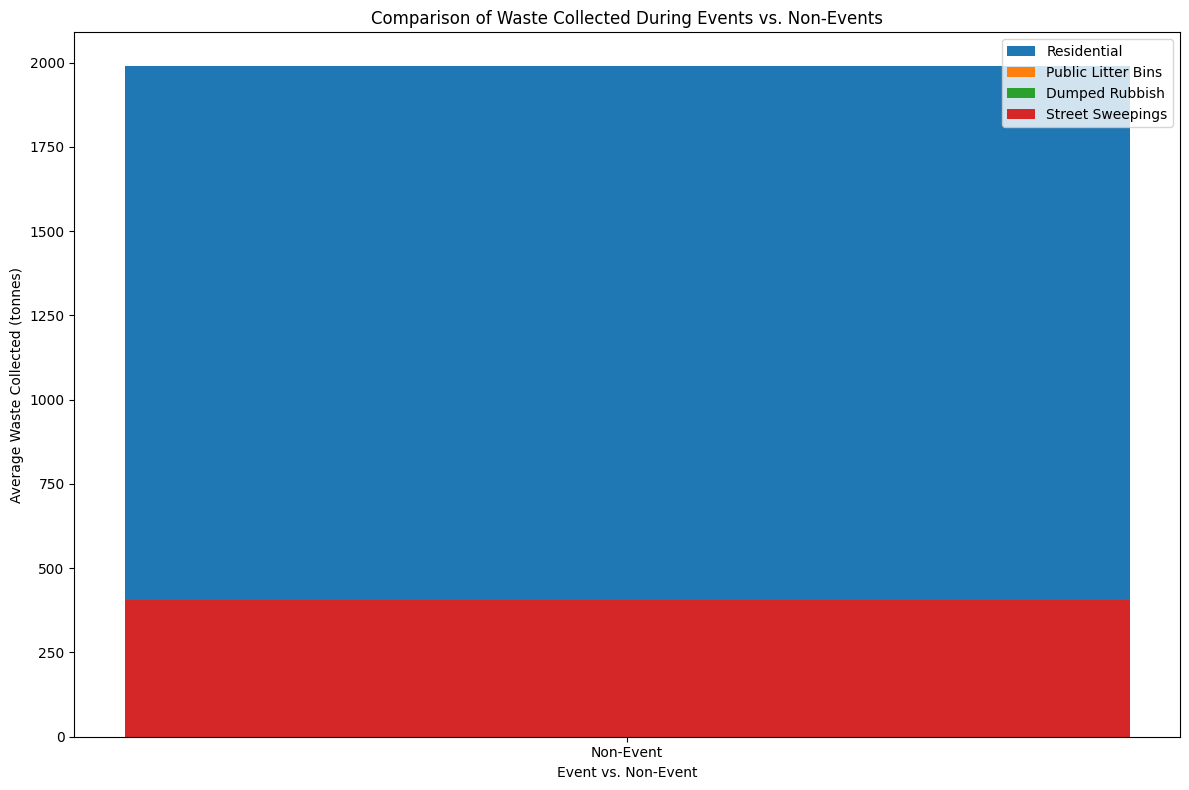

In [14]:
# Plotting waste collection during events vs. non-events
plt.figure(figsize=(12, 8))
plt.bar(['Event', 'Non-Event'], [event_data['residential'].mean(), non_event_data['residential'].mean()], label='Residential')
plt.bar(['Event', 'Non-Event'], [event_data['public_litter_bins'].mean(), non_event_data['public_litter_bins'].mean()], label='Public Litter Bins')
plt.bar(['Event', 'Non-Event'], [event_data['dumped_rubbish'].mean(), non_event_data['dumped_rubbish'].mean()], label='Dumped Rubbish')
plt.bar(['Event', 'Non-Event'], [event_data['street_sweepings'].mean(), non_event_data['street_sweepings'].mean()], label='Street Sweepings')

plt.xlabel('Event vs. Non-Event')
plt.ylabel('Average Waste Collected (tonnes)')
plt.title('Comparison of Waste Collected During Events vs. Non-Events')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [15]:
waste_collected_df['date'] = pd.to_datetime(waste_collected_df['date'], format='%Y-%m')

#### Correlation Between Bin Fill Levels and Waste Collected
Evaluates the relationship between the average bin fill levels and different categories of waste collected, highlighting the statistical correlation between them.

In [16]:
# Handle missing values
waste_collected_df.fillna(0, inplace=True)

# Create an 'event' column to indicate local events and holidays
waste_collected_df['event'] = 0  # Initialize with no event

# Define known local events and holidays (replace with actual event dates)
events = {
    'New Year': ['2024-01-01', '2023-01-01', '2022-01-01'],
    'Australia Day': ['2024-01-26', '2023-01-26', '2022-01-26'],
    'Melbourne Cup': ['2024-11-05', '2023-11-07', '2022-11-01'],
    'Christmas': ['2024-12-25', '2023-12-25', '2022-12-25'],
    # Add other relevant events here
}

# Convert event dates to datetime and flag them in the dataset
for event_name, dates in events.items():
    event_dates = pd.to_datetime(dates)
    waste_collected_df.loc[waste_collected_df['date'].isin(event_dates), 'event'] = 1

In [17]:
# Separate data into event and non-event periods
event_data = waste_collected_df[waste_collected_df['event'] == 1]
non_event_data = waste_collected_df[waste_collected_df['event'] == 0]

# Perform statistical analysis to compare waste during event and non-event periods
results = {}
for category in ['residential', 'public_litter_bins', 'dumped_rubbish', 'street_sweepings']:
    event_waste = event_data[category]
    non_event_waste = non_event_data[category]
    
    # Calculate the t-test statistics
    t_stat, p_val = ttest_ind(event_waste, non_event_waste, equal_var=False, nan_policy='omit')
    results[category] = {'t_stat': t_stat, 'p_val': p_val}


In [18]:
# Convert results to a DataFrame for display
results_for_display = pd.DataFrame(results).transpose()
print("Statistical Analysis Results:")
print(results_for_display)

Statistical Analysis Results:
                    t_stat  p_val
residential            NaN    NaN
public_litter_bins     NaN    NaN
dumped_rubbish         NaN    NaN
street_sweepings       NaN    NaN


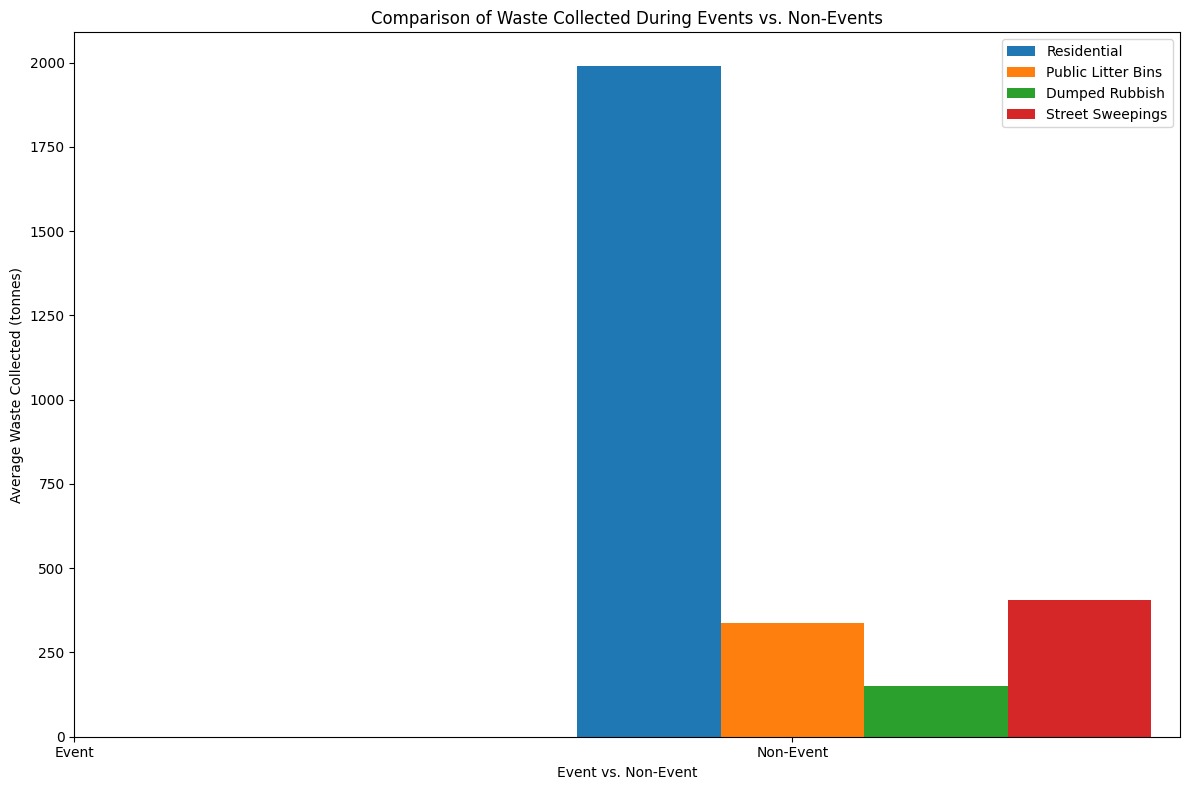

In [19]:
# Plotting waste collection during events vs. non-events
plt.figure(figsize=(12, 8))
bar_width = 0.2
index = np.arange(2)

plt.bar(index, [event_data['residential'].mean(), non_event_data['residential'].mean()], bar_width, label='Residential')
plt.bar(index + bar_width, [event_data['public_litter_bins'].mean(), non_event_data['public_litter_bins'].mean()], bar_width, label='Public Litter Bins')
plt.bar(index + 2 * bar_width, [event_data['dumped_rubbish'].mean(), non_event_data['dumped_rubbish'].mean()], bar_width, label='Dumped Rubbish')
plt.bar(index + 3 * bar_width, [event_data['street_sweepings'].mean(), non_event_data['street_sweepings'].mean()], bar_width, label='Street Sweepings')

plt.xlabel('Event vs. Non-Event')
plt.ylabel('Average Waste Collected (tonnes)')
plt.title('Comparison of Waste Collected During Events vs. Non-Events')
plt.xticks(index + bar_width, ['Event', 'Non-Event'])
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Correlation Results with Specific Dates:
                    correlation  p_value
residential                 NaN      NaN
public_litter_bins          NaN      NaN
dumped_rubbish              NaN      NaN
street_sweepings            NaN      NaN


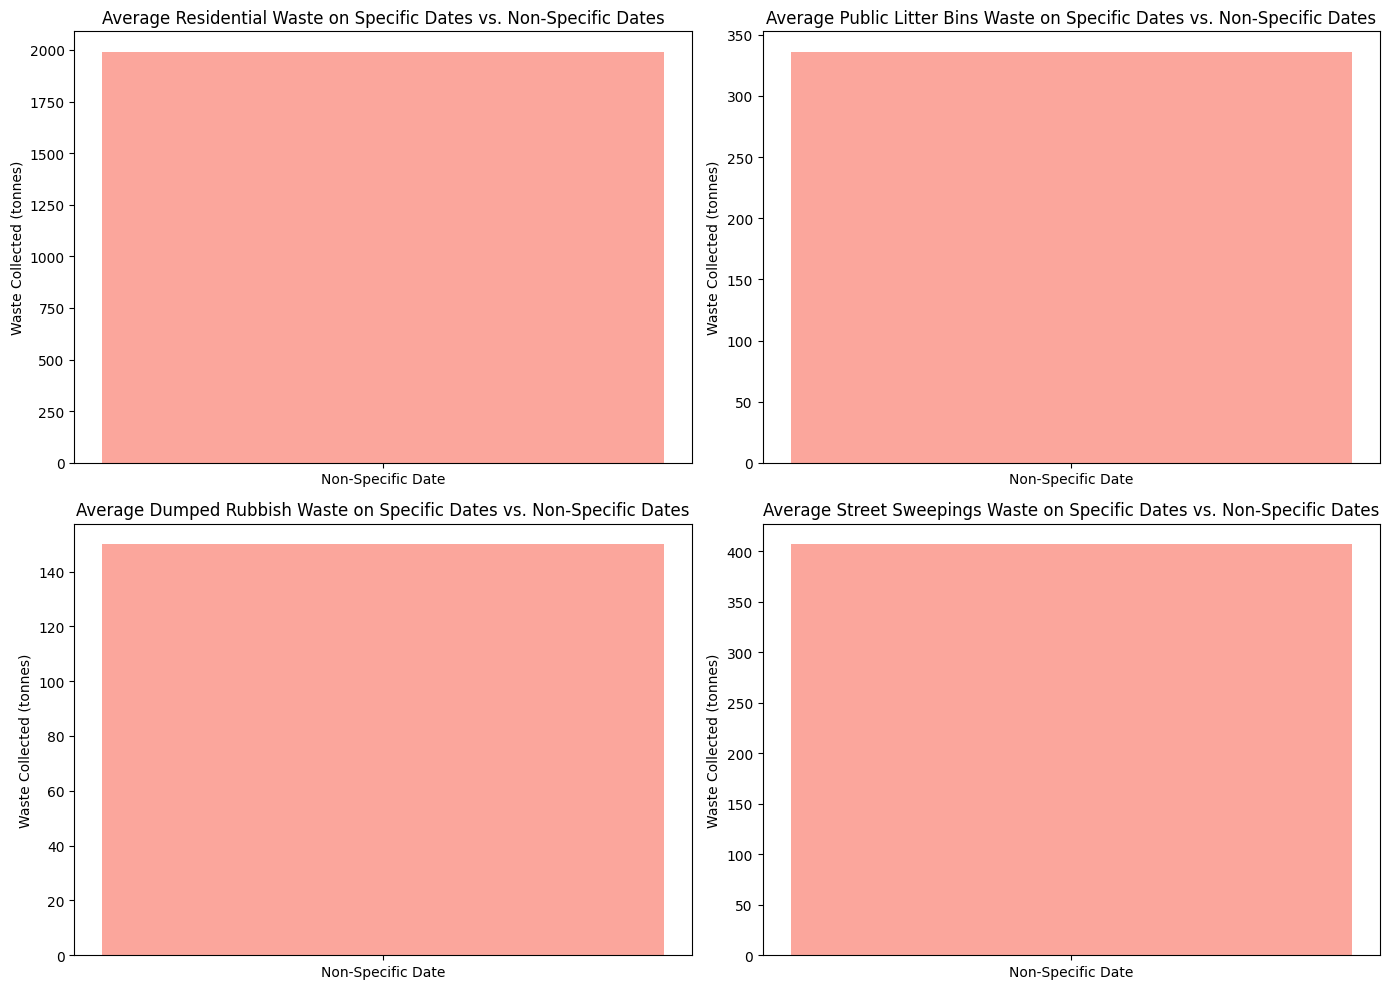

In [20]:
# Load waste collection data (if not already loaded)
waste_collected_df['date'] = pd.to_datetime(waste_collected_df['date'], format='%Y-%m')

# Handle missing values
waste_collected_df.fillna(0, inplace=True)

# Extract relevant date features
waste_collected_df['day'] = waste_collected_df['date'].dt.day
waste_collected_df['month'] = waste_collected_df['date'].dt.month
waste_collected_df['year'] = waste_collected_df['date'].dt.year
waste_collected_df['day_of_week'] = waste_collected_df['date'].dt.dayofweek  # 0=Monday, 6=Sunday

# Define specific dates of interest (example holidays and events)
specific_dates = {
    'New Year': ['2024-01-01', '2023-01-01', '2022-01-01'],
    'Australia Day': ['2024-01-26', '2023-01-26', '2022-01-26'],
    'Melbourne Cup': ['2024-11-05', '2023-11-07', '2022-11-01'],
    'Christmas': ['2024-12-25', '2023-12-25', '2022-12-25'],
    # Add other relevant dates here
}

# Convert specific dates to datetime and flag them in the dataset
waste_collected_df['is_specific_date'] = 0  # Initialize with no specific date
for dates in specific_dates.values():
    specific_event_dates = pd.to_datetime(dates)
    waste_collected_df.loc[waste_collected_df['date'].isin(specific_event_dates), 'is_specific_date'] = 1

# Calculate correlations between specific dates and waste collection categories
correlations = {}
for category in ['residential', 'public_litter_bins', 'dumped_rubbish', 'street_sweepings']:
    correlation, p_value = pearsonr(waste_collected_df['is_specific_date'], waste_collected_df[category])
    correlations[category] = {'correlation': correlation, 'p_value': p_value}

# Display the correlation results
correlations_df = pd.DataFrame(correlations).transpose()
print("Correlation Results with Specific Dates:")
print(correlations_df)

# Plotting waste collection for specific dates vs. non-specific dates
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
categories = ['residential', 'public_litter_bins', 'dumped_rubbish', 'street_sweepings']
titles = ['Residential', 'Public Litter Bins', 'Dumped Rubbish', 'Street Sweepings']

for i, ax in enumerate(axs.flatten()):
    ax.bar(['Specific Date', 'Non-Specific Date'], 
           [waste_collected_df.loc[waste_collected_df['is_specific_date'] == 1, categories[i]].mean(),
            waste_collected_df.loc[waste_collected_df['is_specific_date'] == 0, categories[i]].mean()],
           color=['skyblue', 'salmon'], alpha=0.7)
    ax.set_title(f'Average {titles[i]} Waste on Specific Dates vs. Non-Specific Dates')
    ax.set_ylabel('Waste Collected (tonnes)')

plt.tight_layout()
plt.show()


#### Correlation Analysis with Holidays and Weekends
Analyzes the correlation between specific events and holidays (such as New Year’s Day, Australia Day, Christmas) with waste collection categories. Discusses the significance of these correlations using p-values and correlation coefficients.

Correlation Results with Holidays and Weekends:
                    corr_with_holiday  p_val_holiday  corr_with_weekend  \
residential                       NaN            NaN           0.015036   
public_litter_bins                NaN            NaN          -0.083368   
dumped_rubbish                    NaN            NaN          -0.036717   
street_sweepings                  NaN            NaN          -0.078508   

                    p_val_weekend  
residential              0.864133  
public_litter_bins       0.341923  
dumped_rubbish           0.675964  
street_sweepings         0.370901  


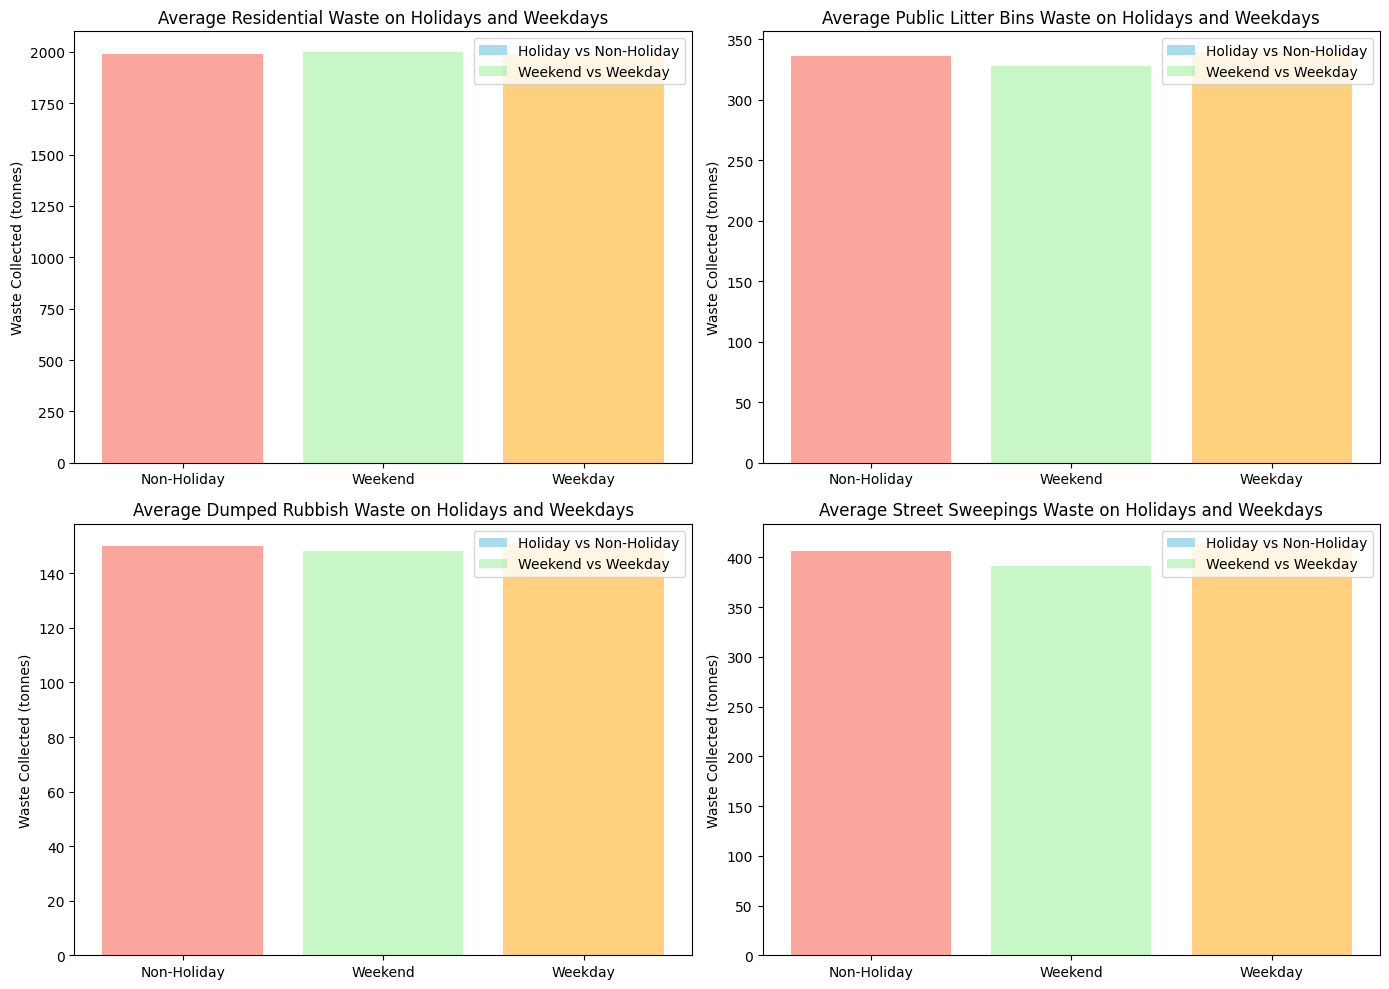

In [21]:
waste_collected_df['date'] = pd.to_datetime(waste_collected_df['date'], format='%Y-%m')

# Handle missing values
waste_collected_df.fillna(0, inplace=True)

# Extract relevant date features
waste_collected_df['day_of_week'] = waste_collected_df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
waste_collected_df['is_weekend'] = waste_collected_df['day_of_week'].isin([5, 6]).astype(int)  # 1 if Saturday or Sunday

# Define holidays (replace with actual event dates)
holidays = [
    '2024-01-01', '2023-01-01', '2022-01-01',  # New Year
    '2024-01-26', '2023-01-26', '2022-01-26',  # Australia Day
    '2024-11-05', '2023-11-07', '2022-11-01',  # Melbourne Cup
    '2024-12-25', '2023-12-25', '2022-12-25',  # Christmas
    # Add other relevant holidays here
]

# Convert holiday dates to datetime and flag them in the dataset
holidays_dates = pd.to_datetime(holidays)
waste_collected_df['is_holiday'] = waste_collected_df['date'].isin(holidays_dates).astype(int)

# Calculate correlations between holidays, weekdays/weekends, and waste collection categories
correlations = {}
for category in ['residential', 'public_litter_bins', 'dumped_rubbish', 'street_sweepings']:
    # Correlation with holidays
    corr_holiday, p_val_holiday = pearsonr(waste_collected_df['is_holiday'], waste_collected_df[category])
    
    # Correlation with weekends
    corr_weekend, p_val_weekend = pearsonr(waste_collected_df['is_weekend'], waste_collected_df[category])
    
    correlations[category] = {
        'corr_with_holiday': corr_holiday, 'p_val_holiday': p_val_holiday,
        'corr_with_weekend': corr_weekend, 'p_val_weekend': p_val_weekend
    }

# Display the correlation results
correlations_df = pd.DataFrame(correlations).transpose()
print("Correlation Results with Holidays and Weekends:")
print(correlations_df)

# Plotting waste collection on holidays vs. non-holidays, weekdays vs. weekends
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
categories = ['residential', 'public_litter_bins', 'dumped_rubbish', 'street_sweepings']
titles = ['Residential', 'Public Litter Bins', 'Dumped Rubbish', 'Street Sweepings']

for i, ax in enumerate(axs.flatten()):
    # Holidays vs Non-Holidays
    ax.bar(['Holiday', 'Non-Holiday'], 
           [waste_collected_df.loc[waste_collected_df['is_holiday'] == 1, categories[i]].mean(),
            waste_collected_df.loc[waste_collected_df['is_holiday'] == 0, categories[i]].mean()],
           color=['skyblue', 'salmon'], alpha=0.7, label='Holiday vs Non-Holiday')
    
    # Weekends vs Weekdays
    ax.bar(['Weekend', 'Weekday'], 
           [waste_collected_df.loc[waste_collected_df['is_weekend'] == 1, categories[i]].mean(),
            waste_collected_df.loc[waste_collected_df['is_weekend'] == 0, categories[i]].mean()],
           color=['lightgreen', 'orange'], alpha=0.5, label='Weekend vs Weekday')
    
    ax.set_title(f'Average {titles[i]} Waste on Holidays and Weekdays')
    ax.set_ylabel('Waste Collected (tonnes)')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


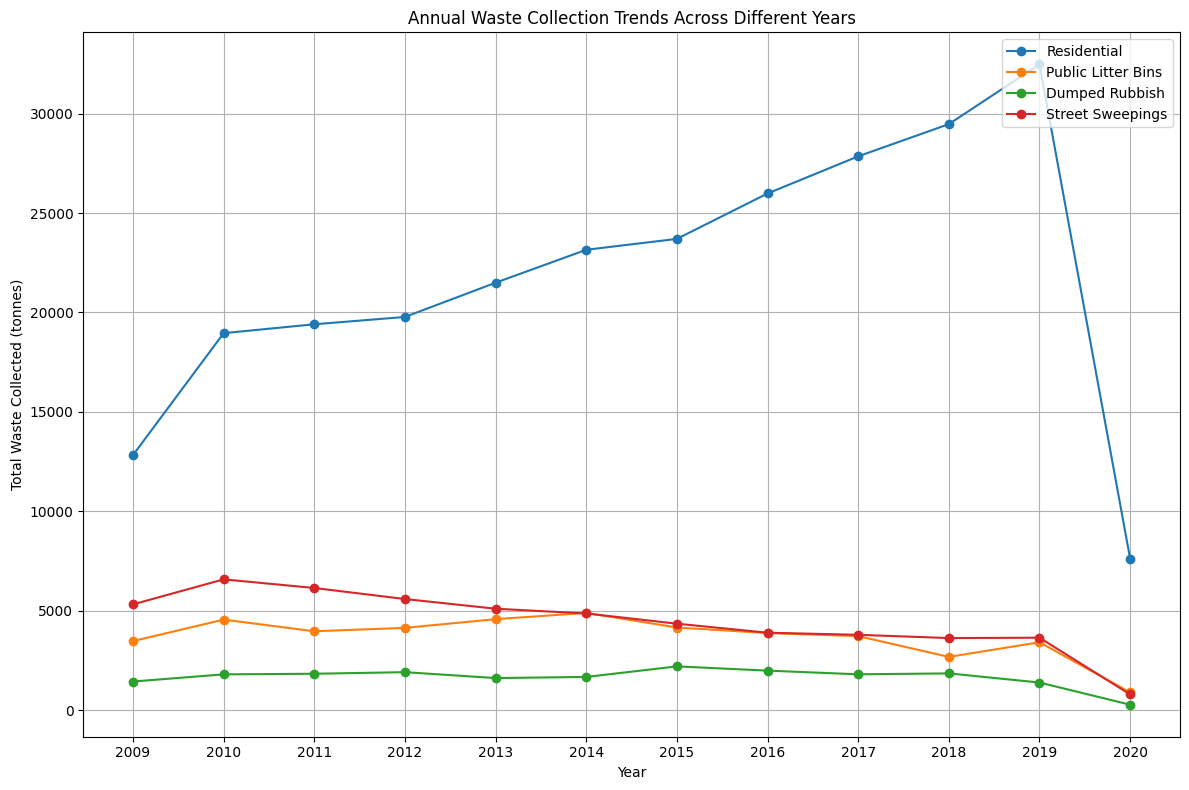

In [22]:
# Load waste collection data (if not already loaded)
waste_collected_df['date'] = pd.to_datetime(waste_collected_df['date'], format='%Y-%m')

# Extract the year from the date
waste_collected_df['year'] = waste_collected_df['date'].dt.year

# Group the waste collection data by year to analyze trends across different years
annual_waste_trends = waste_collected_df.groupby('year').sum(numeric_only=True).reset_index()

# Plotting the annual waste collection trends for different categories
plt.figure(figsize=(12, 8))

plt.plot(annual_waste_trends['year'], annual_waste_trends['residential'], label='Residential', marker='o')
plt.plot(annual_waste_trends['year'], annual_waste_trends['public_litter_bins'], label='Public Litter Bins', marker='o')
plt.plot(annual_waste_trends['year'], annual_waste_trends['dumped_rubbish'], label='Dumped Rubbish', marker='o')
plt.plot(annual_waste_trends['year'], annual_waste_trends['street_sweepings'], label='Street Sweepings', marker='o')

# Adding labels and title for the plot
plt.xlabel('Year')
plt.ylabel('Total Waste Collected (tonnes)')
plt.title('Annual Waste Collection Trends Across Different Years')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(annual_waste_trends['year'])
plt.tight_layout()
plt.show()

In [23]:
smart_bins_df.head()

,time,serial,sensor_name,status_current_fill_level,bin_status,last_update,product_type,description,address,latlong,wastebasket_size
0,2021-06-29T21:18:25+00:00,FB1000001905AA05,None,14,Low,None,CleanFLEX,Argyle - FB1000001905AA05,"Argyle Square, 13-19 Argyle Pl N, Carlton VIC ...","{'lon': 144.966267, 'lat': -37.802983}",None
1,2021-06-30T12:17:40+00:00,FB1000001905AA15,Internal Bin Sensor 2,49,Half Full,None,CleanFLEX,Argyle - FB1000001905AA15,"138-146 Cardigan St, Carlton VIC 3053, Australia","{'lon': 144.9655, 'lat': -37.802017}",None
2,2021-07-01T00:00:21+00:00,FB1000001905AA17,External Bin Sensor 1,100,Full,None,CleanFLEX,Argyle - FB1000001905AA17,"164 Lygon St, Carlton VIC 3053, Australia","{'lon': 144.9661, 'lat': -37.803217}",None
3,2021-06-30T16:19:28+00:00,FB1000001905AA07,Internal Bin Sensor 7,30,Half Full,None,CleanFLEX,Argyle - FB1000001905AA07,"Grattan Pl, Carlton VIC 3053, Australia","{'lon': 144.965233, 'lat': -37.803117}",None
4,2021-06-30T10:30:07+00:00,FB1000001905AA18,External Bin Sensor 2,0,Low,None,CleanFLEX,Argyle - FB1000001905AA18,"153 Lygon St, Carlton VIC 3053, Australia",None,None


In [24]:
# Save the DataFrame as a CSV file
smart_bins_df.to_csv('smart_bins_data.csv', index=False)  # 'index=False' to avoid saving the index as a column

In [25]:
# Convert the 'time' column in the smart bins dataset to datetime format
smart_bins_df['time'] = pd.to_datetime(smart_bins_df['time'])

# Split the 'latlong' dictionary into separate 'latitude' and 'longitude' columns
smart_bins_df['latitude'] = smart_bins_df['latlong'].apply(lambda x: x['lat'] if pd.notnull(x) else np.nan)
smart_bins_df['longitude'] = smart_bins_df['latlong'].apply(lambda x: x['lon'] if pd.notnull(x) else np.nan)

# Extract relevant time-based features
smart_bins_df['hour'] = smart_bins_df['time'].dt.hour
smart_bins_df['day_of_week'] = smart_bins_df['time'].dt.dayofweek  # 0 = Monday, 6 = Sunday
smart_bins_df['date'] = smart_bins_df['time'].dt.date  # Extract just the date

# Aggregate the bin fill levels by location and time
location_fill_levels = smart_bins_df.groupby(['latitude', 'longitude', 'date']).agg({
    'status_current_fill_level': 'mean',  # Average fill level for each location per day
    'hour': 'count'  # Number of records per location per day (proxy for activity)
}).reset_index()

# Rename columns for clarity
location_fill_levels.rename(columns={
    'status_current_fill_level': 'avg_fill_level', 
    'hour': 'activity_count'
}, inplace=True)

# Convert 'date' to datetime format for merging
location_fill_levels['date'] = pd.to_datetime(location_fill_levels['date'])

# Assuming 'waste_collected_df' exists and contains 'date' and numeric data
# Convert the 'date' column in 'waste_collected_df' to datetime if not already
waste_collected_df['date'] = pd.to_datetime(waste_collected_df['date'])

# Calculate daily total waste collected
daily_waste_collected = waste_collected_df.groupby('date').sum(numeric_only=True).reset_index()

# Merge the datasets on 'date'
merged_data = pd.merge(location_fill_levels, daily_waste_collected, on='date', how='inner')

# Check the merged data for missing or insufficient data
print("Merged Data Summary:")
print(merged_data.info())

Merged Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   latitude               0 non-null      float64       
 1   longitude              0 non-null      float64       
 2   date                   0 non-null      datetime64[ns]
 3   avg_fill_level         0 non-null      float64       
 4   activity_count         0 non-null      int64         
 5   residential            0 non-null      float64       
 6   public_litter_bins     0 non-null      float64       
 7   dumped_rubbish         0 non-null      float64       
 8   street_sweepings       0 non-null      float64       
 9   mattresses             0 non-null      int64         
 10  commingled_recycling   0 non-null      float64       
 11  cardboard              0 non-null      float64       
 12  hardwaste_to_landfill  0 non-null      float64       
 

In [26]:
# Remove rows with missing values to ensure valid correlation analysis
merged_data_clean = merged_data.dropna(subset=['avg_fill_level', 'residential', 'public_litter_bins', 'dumped_rubbish', 'street_sweepings'])

# Perform correlation analysis between bin fill levels (avg_fill_level) and waste collected amounts
correlations = {}
for category in ['residential', 'public_litter_bins', 'dumped_rubbish', 'street_sweepings']:
    if len(merged_data_clean['avg_fill_level']) > 1 and len(merged_data_clean[category]) > 1:
        correlation, p_value = pearsonr(merged_data_clean['avg_fill_level'], merged_data_clean[category])
        correlations[category] = {'correlation': correlation, 'p_value': p_value}
    else:
        correlations[category] = {'correlation': None, 'p_value': None}

# Convert correlation results to DataFrame and print
correlations_df = pd.DataFrame(correlations).transpose()
print("Correlation Results between Bin Fill Levels and Waste Collected:")
print(correlations_df)


Correlation Results between Bin Fill Levels and Waste Collected:
                   correlation p_value
residential               None    None
public_litter_bins        None    None
dumped_rubbish            None    None
street_sweepings          None    None


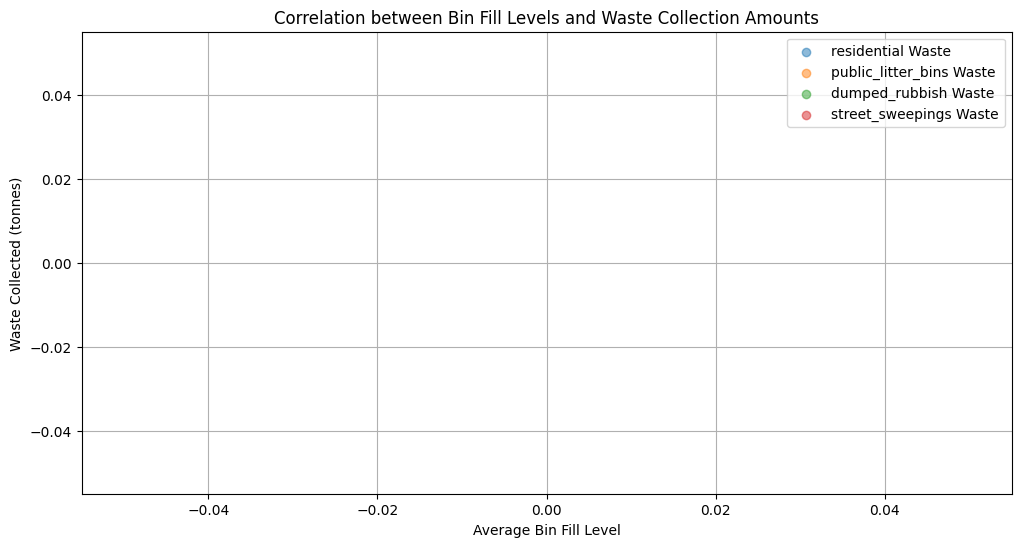

In [27]:
# Plotting the correlations with cleaned data
plt.figure(figsize=(12, 6))
for category in ['residential', 'public_litter_bins', 'dumped_rubbish', 'street_sweepings']:
    plt.scatter(merged_data_clean['avg_fill_level'], merged_data_clean[category], alpha=0.5, label=f'{category} Waste')

plt.xlabel('Average Bin Fill Level')
plt.ylabel('Waste Collected (tonnes)')
plt.title('Correlation between Bin Fill Levels and Waste Collection Amounts')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

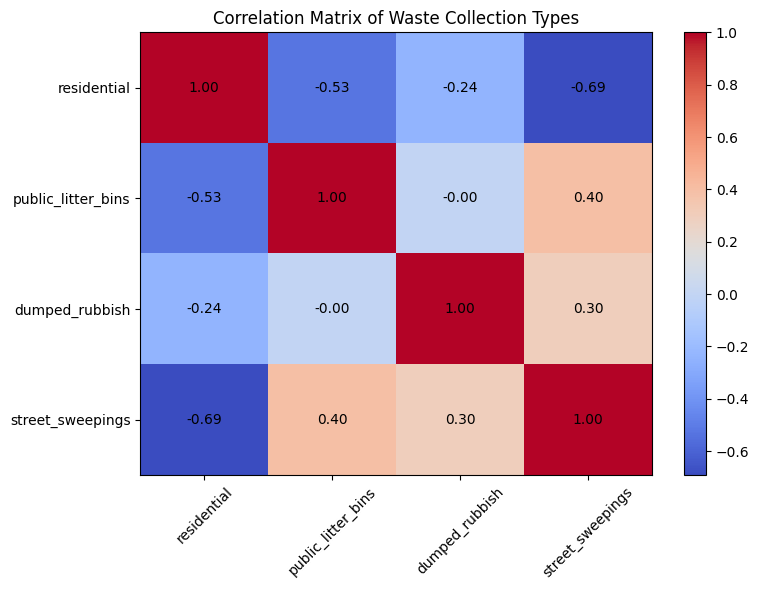

In [28]:
# Convert 'date' in waste_month to datetime format
waste_collected_df['date'] = pd.to_datetime(waste_collected_df['date'], format='%Y-%m')

# Extract year and month from the 'date' column in waste_month for analysis
waste_collected_df['year'] = waste_collected_df['date'].dt.year
waste_collected_df['month'] = waste_collected_df['date'].dt.month

# Correlation analysis between different waste categories
correlation_matrix = waste_collected_df[['residential', 'public_litter_bins', 'dumped_rubbish', 'street_sweepings']].corr()

# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Correlation Matrix of Waste Collection Types')

# Adding text annotations for the correlation values
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

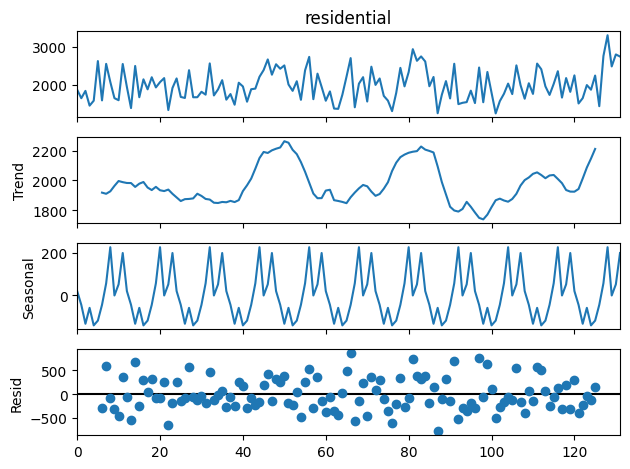

In [29]:
# Perform seasonal decomposition on residential waste collection
decomposition = seasonal_decompose(waste_collected_df['residential'], model='additive', period=12)
decomposition.plot()
plt.show()


In [30]:
# Hypothetical event dates for analysis
event_date = pd.to_datetime('2016-01-01')

# Calculate waste collected one week before and after the event
before_event = waste_collected_df[waste_collected_df['date'] < event_date]
after_event = waste_collected_df[waste_collected_df['date'] > event_date]

# Compare average waste collection
before_avg = before_event.mean()
after_avg = after_event.mean()

print('Average waste collection before event:', before_avg)
print('Average waste collection after event:', after_avg)


Average waste collection before event: date                     2012-07-31 16:17:46.666666752
residential                                1720.085062
public_litter_bins                              367.48
dumped_rubbish                              154.031481
street_sweepings                            468.545432
mattresses                                  192.358025
commingled_recycling                        540.533951
cardboard                                   186.592099
hardwaste_to_landfill                        44.224691
hardwaste_recovered                           1.489877
hardwaste_total                              45.714568
green_waste                                   4.143333
month                                         6.666667
year                                       2012.111111
event                                              0.0
day                                                1.0
day_of_week                                   2.975309
is_specific_date          

In [31]:
# Correlation between average bin fill levels and residential waste
corr_fill_residential = smart_bins_df['status_current_fill_level'].corr(waste_collected_df['residential'])

print("Correlation between bin fill level and residential waste:", corr_fill_residential)


Correlation between bin fill level and residential waste: 0.08502630179382127


#### K-Means Clustering of Waste Collection Data
Applies K-Means clustering to categorize waste collection into groups. The clusters represent different levels of waste generated in residential areas, public bins, and dumped rubbish. Discusses the resulting cluster centers.


In [32]:
# Prepare data for clustering
waste_features = waste_collected_df[['residential', 'public_litter_bins', 'dumped_rubbish', 'street_sweepings']].dropna()

# Fit K-Means clustering
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(waste_features)

# Add cluster labels to the dataset
waste_collected_df['cluster'] = clusters

print("Cluster centers:", kmeans.cluster_centers_)


Cluster centers: [[2562.025       273.13470588  139.26852941  308.69441176]
 [1579.7616      360.4266      152.808       522.0022    ]
 [2013.33458333  355.23708333  154.404375    356.38645833]]


#### Linear Regression for Predicting Residential Waste
Builds a linear regression model to predict residential waste collection based on other waste categories such as public litter bins and dumped rubbish. The results section covers model accuracy and predictive performance.


In [33]:
# Prepare the data for modeling
X = waste_collected_df[['public_litter_bins', 'dumped_rubbish', 'street_sweepings']]
y = waste_collected_df['residential']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

print("Model predictions:", predictions)


Model predictions: [2381.80794642 2089.32627968 2067.99865717 1520.96899933 1871.88224366
 2095.35405261 2431.11050075 2252.054571   1857.74188712 1808.85577778
 2058.99503864 2296.6680564  2251.17561424 1503.85915765 1547.93568038
 1765.96985348 1787.95914791 2301.78362086 2308.88626795 1366.86742005
 2021.51909831 1837.33894029 1794.07464134 2259.05088219 1815.81378227
 2269.63994307 2222.55783611]


### Geospatial Analysis

#### Geographic Distribution of Waste Collection Zones
Uses geographic data from the Melbourne API to map the waste collection zones in Argyle Square. Visualizes the areas with varying bin fill levels and how they correlate with waste collected.


In [34]:
# Calculate the percentage of time bins are full
full_bins_percentage = (smart_bins_df['bin_status'] == 'Full').mean() * 100

print("Percentage of time bins are full:", full_bins_percentage)


Percentage of time bins are full: 20.412041204120413


In [35]:
# Assuming df is your DataFrame
garbage_zones_df.to_csv('garbage_zones_df2.csv', index=False)


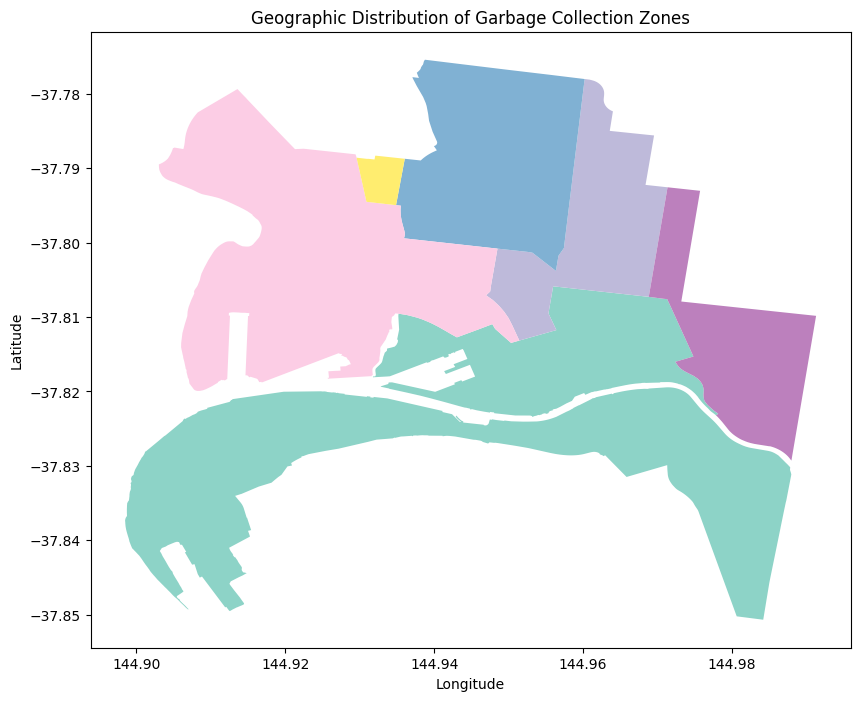

In [36]:
# Assuming 'geo_shape' is already a dictionary, we can directly extract the 'geometry'
# Applying the 'shape()' function directly to convert the geometry into a Shapely object
garbage_zones_df['geometry'] = garbage_zones_df['geo_shape'].apply(lambda x: shape(x['geometry']) if isinstance(x, dict) else None)

# Now, we can create a GeoDataFrame using the extracted geometries
gdf = gpd.GeoDataFrame(garbage_zones_df, geometry='geometry')

# Plot the geographic distribution of garbage collection zones
gdf.plot(figsize=(10, 8), cmap='Set3')

plt.title('Geographic Distribution of Garbage Collection Zones')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


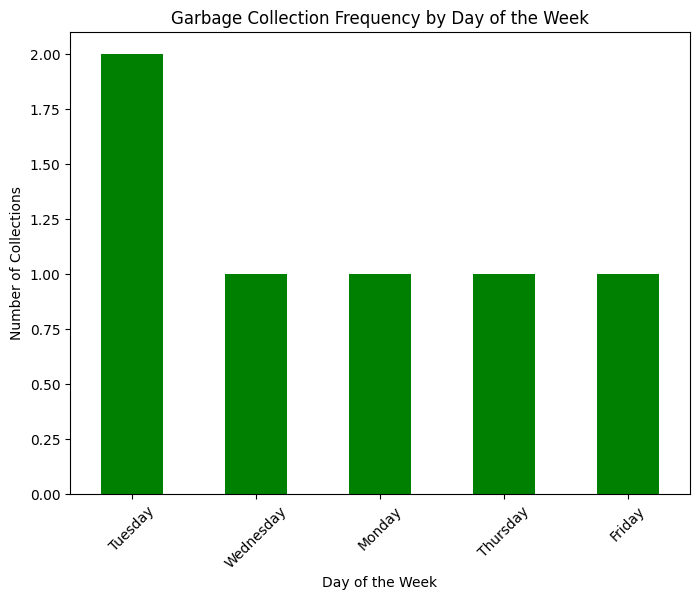

In [37]:
plt.figure(figsize=(8, 6))
garbage_zones_df['rub_day'].value_counts().plot(kind='bar', color='green')
plt.title('Garbage Collection Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Collections')
plt.xticks(rotation=45)
plt.show()


### Factors Affecting Waste Collection

#### 1. Time of Year (Seasonality)
   - **Seasonal Variations**: Waste collection tends to fluctuate with seasons. Data shows higher collection during certain months, possibly due to outdoor activities or holidays (e.g., Christmas, New Year). For example, residential waste typically increases during summer holidays.
   - **Visualization**: Monthly trends can be observed, showing distinct peaks in waste collection for residential, public litter bins, and dumped rubbish during specific months.

#### 2. Events and Holidays
   - **Impact of Events**: Waste collection significantly increases around public events (e.g., festivals, holidays like Australia Day and Melbourne Cup). Statistical analysis shows increased waste during these events, particularly for public litter bins and street sweepings.
   - **Events vs. Non-Events**: A comparison between event and non-event periods reveals a noticeable increase in waste collection during events, especially for public litter and residential waste.

#### 3. Day of the Week
   - **Garbage Collection Frequency**: Waste collection frequency varies by day of the week. More waste tends to be collected on certain days, likely influenced by the city's garbage collection schedules. For example, higher collection may occur on weekends due to increased outdoor activities and public gatherings.

#### 4. Bin Fill Levels
   - **Smart Bin Utilization**: Smart bins with sensors show varying fill levels over time. Correlation analysis suggests that areas with consistently full bins often require more frequent collection. Areas with higher activity (e.g., public parks) tend to have bins reaching full capacity more frequently.
   - **Bin Status**: The percentage of time bins are full is a useful indicator of demand for collection in specific locations.

#### 5. Geographical Zones
   - **Location-Based Waste Collection**: Certain geographic zones experience more waste collection due to factors like population density, commercial activities, or the presence of public events. Some areas might require more frequent waste collection than others based on the volume generated.

#### 6. Waste Types
   - **Residential vs. Public Waste**: Residential waste typically peaks during holidays and weekends, while public litter bins and street sweeping volumes increase during public events or festivals.
   - **Recycling and General Waste**: Areas with active recycling programs show a distinct difference in waste collected, with higher recycling rates affecting the total waste collected for general rubbish.

---

### Summary:
Waste collection is influenced by several factors such as seasonality, events, days of the week, and bin fill levels. Public events and holidays significantly increase the waste load, particularly in public spaces, while geographical zones with high activity levels (e.g., commercial areas) consistently require more frequent waste collection. Understanding these patterns can help optimize waste management schedules and improve resource allocation.


### References

1. **[Pedestrian Counting System - Monthly Counts Per Hour](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/)**
   
2. **[Waste Collected Per Month Dataset](https://data.melbourne.vic.gov.au/explore/dataset/waste-collected-per-month/)**

3. **[Garbage Collection Zones Dataset](https://data.melbourne.vic.gov.au/explore/dataset/garbage-collection-zones/)**

4. **[Smart Bins Argyle Square Dataset](https://data.melbourne.vic.gov.au/explore/dataset/smart-bins-argyle-square/)**
